# Hands-on introduction to ML training
In this notebook, we will look at selecting the best model and best parameters for a dataset about car acceptability.

### Step 1: Load and explore data
The first step is figuring out the data source. In this case we will use a pre-existing dataset. We will:
1. Create a folder 'data'
2. Download the file from public github repo using python package "requests" and save the car.csv file in the data folder.

In [2]:
%config IPCompleter.greedy=True #Helps with auto-complete

import numpy as np
import pandas as pd
import os

try:
    os.mkdir('data')
except OSError as error:
    print(error)

import requests, csv

url = 'https://raw.githubusercontent.com/techno-nerd/ML_101_Course/main/06%20Models%20and%20Hyperparameters/data/car.csv'
r = requests.get(url)
with open('data/car.csv', 'w') as f:
  writer = csv.writer(f)
  for line in r.iter_lines():
    writer.writerow(line.decode('utf-8').split(','))

[Errno 17] File exists: 'data'


In [3]:
df = pd.read_csv('data/car.csv')

In [4]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1728 entries, 0 to 1727
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Buying_Price       1728 non-null   object
 1   Maintenance_Price  1728 non-null   object
 2   No_of_Doors        1728 non-null   object
 3   Person_Capacity    1728 non-null   object
 4   Size_of_Luggage    1728 non-null   object
 5   Safety             1728 non-null   object
 6   Car_Acceptability  1728 non-null   object
dtypes: object(7)
memory usage: 94.6+ KB
None


In [5]:
print(df[:5])

  Buying_Price Maintenance_Price No_of_Doors Person_Capacity Size_of_Luggage  \
0        vhigh             vhigh           2               2           small   
1        vhigh             vhigh           2               2           small   
2        vhigh             vhigh           2               2           small   
3        vhigh             vhigh           2               2             med   
4        vhigh             vhigh           2               2             med   

  Safety Car_Acceptability  
0    low             unacc  
1    med             unacc  
2   high             unacc  
3    low             unacc  
4    med             unacc  


In [6]:
print(df['No_of_Doors'].value_counts())

No_of_Doors
2        432
3        432
4        432
5more    432
Name: count, dtype: int64


In [7]:
print(df['Person_Capacity'].value_counts())

Person_Capacity
2       576
4       576
more    576
Name: count, dtype: int64


In [8]:
print(df['Car_Acceptability'].value_counts())

Car_Acceptability
unacc    1210
acc       384
good       69
vgood      65
Name: count, dtype: int64


[Kaggle Dataset](https://www.kaggle.com/datasets/subhajeetdas/car-acceptability-classification-dataset) <br>
The data is from Kaggle. It contains data on various cars and aspects such as buying price and capacity. We will use this data set to predict whether the car would be acceptable or not.

### Step 2: Data preparation

There are a few tasks we need to do before we can train the model on this data:
1. Improve representation of vgood and good cars
2. One-hot encode categorical features

Then, we will split the data the same way as last time:
1. Split the data into training set (80%) and test set (20%)
2. Separate the input features (details about the car) from target variable ("Car_Acceptability")

In [9]:
temp = df[df['Car_Acceptability'] == 'good']
print(temp.shape)

(69, 7)


In [10]:
#Duplicating class "good" 5 times

temp = df[df['Car_Acceptability'] == 'good']
print(temp.shape)
for i in range(1, 6):
    df = pd.concat([df, temp], axis=0, ignore_index=True)

print(df['Car_Acceptability'].value_counts())

(69, 7)
Car_Acceptability
unacc    1210
good      414
acc       384
vgood      65
Name: count, dtype: int64


In [11]:
#Duplicating class "vgood" 5 times

temp2 = df[df['Car_Acceptability'] == 'vgood']
for i in range(1, 6):
    df = pd.concat([df, temp2], axis=0, ignore_index=True)

print(df['Car_Acceptability'].value_counts())

Car_Acceptability
unacc    1210
good      414
vgood     390
acc       384
Name: count, dtype: int64


In [13]:
features = pd.DataFrame()
for col in df.drop(['Car_Acceptability'], axis=1):
    one_hot = pd.get_dummies(df[col])
    cols = []
    for column in one_hot.columns:
        cols.append(f"{column}_{col}")
    
    one_hot.columns = cols
    features = pd.concat([features, one_hot], axis=1)

print(features[:5])

   high_Buying_Price  low_Buying_Price  med_Buying_Price  vhigh_Buying_Price  \
0              False             False             False                True   
1              False             False             False                True   
2              False             False             False                True   
3              False             False             False                True   
4              False             False             False                True   

   high_Maintenance_Price  low_Maintenance_Price  med_Maintenance_Price  \
0                   False                  False                  False   
1                   False                  False                  False   
2                   False                  False                  False   
3                   False                  False                  False   
4                   False                  False                  False   

   vhigh_Maintenance_Price  2_No_of_Doors  3_No_of_Doors  ...  \
0  

In [14]:
for colName in features.columns:
    if features[colName].dtype == bool:
        features[colName].replace({False:0, True:1}, inplace=True)

/tmp/ipykernel_3360/3267920063.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  features[colName].replace({False:0, True:1}, inplace=True)
/tmp/ipykernel_3360/3267920063.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  features[colName].replace({False:0, True:1}, inplace=True)


In [15]:
import sklearn.model_selection as ms

train_features, test_features, train_labels, test_labels = ms.train_test_split(features, df['Car_Acceptability'], test_size=0.2)
print(train_features.shape)
print(test_features.shape)
print(train_labels.shape)
print(test_labels.shape)

(1918, 21)
(480, 21)
(1918,)
(480,)


### Step 3: Model Selection and Training

To decide on the best model, we will run two experiments:
1. Which model is the best
2. Which parameters for that model are the best

Then, we will train the best model with the best parameters and see how well it performs.

#### Random Forest Classifier

In [16]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier()
params_grid = {'n_estimators':[5, 10, 15],
               'max_depth': [None, 3, 5, 7],
               'min_samples_leaf': [1, 3, 5]}

grid_search = GridSearchCV(model, params_grid, cv=3, scoring='accuracy')
grid_search.fit(train_features, train_labels)



GridSearchCV(cv=3, estimator=RandomForestClassifier(),
             param_grid={'max_depth': [None, 3, 5, 7],
                         'min_samples_leaf': [1, 3, 5],
                         'n_estimators': [5, 10, 15]},
             scoring='accuracy')

In [17]:
best_model = grid_search.best_estimator_
print("Best model:", best_model)

best_params = grid_search.best_params_
print("Best parameters:", best_params)


Best model: RandomForestClassifier(n_estimators=15)
Best parameters: {'max_depth': None, 'min_samples_leaf': 1, 'n_estimators': 15}


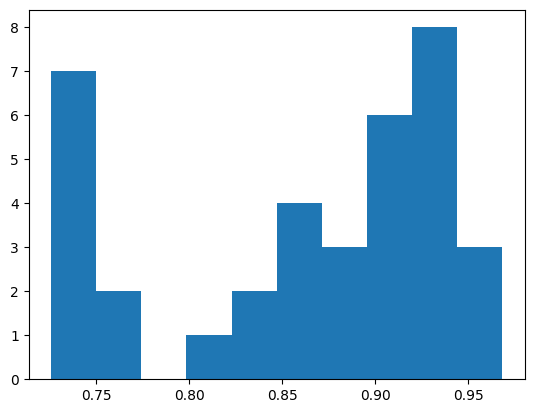

In [18]:
import matplotlib.pyplot as plt
results = grid_search.cv_results_['mean_test_score']
plt.hist(results)
plt.show()

In [19]:
test_score = best_model.score(test_features, test_labels)
print("Test Score: ", test_score)


Test Score:  0.9729166666666667


#### Decision Tree Classifier

In [20]:
from sklearn.tree import DecisionTreeClassifier

model = DecisionTreeClassifier()
params_grid = {'max_depth': [None, 3, 5, 7],
               'min_samples_leaf': [1, 3, 5],
               'splitter':["best", "random"]}

grid_search = GridSearchCV(model, params_grid, cv=3, scoring='accuracy')
grid_search.fit(train_features, train_labels)

GridSearchCV(cv=3, estimator=DecisionTreeClassifier(),
             param_grid={'max_depth': [None, 3, 5, 7],
                         'min_samples_leaf': [1, 3, 5],
                         'splitter': ['best', 'random']},
             scoring='accuracy')

In [21]:
best_model = grid_search.best_estimator_
print("Best model:", best_model)

best_params = grid_search.best_params_
print("Best parameters:", best_params)

Best model: DecisionTreeClassifier()
Best parameters: {'max_depth': None, 'min_samples_leaf': 1, 'splitter': 'best'}


In [22]:
test_score = best_model.score(test_features, test_labels)
print("Test Score: ", test_score)

Test Score:  0.98125


#### KNN Classifier

In [23]:
from sklearn.neighbors import KNeighborsClassifier

model = KNeighborsClassifier()
params_grid = {'weights': ['uniform', 'distance'],
               'n_neighbors': [3, 5, 10]
               }
grid_search = GridSearchCV(model, params_grid, cv=3, scoring='accuracy')
grid_search.fit(train_features, train_labels)

GridSearchCV(cv=3, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': [3, 5, 10],
                         'weights': ['uniform', 'distance']},
             scoring='accuracy')

In [24]:
best_model = grid_search.best_estimator_
print("Best model:", best_model)

best_params = grid_search.best_params_
print("Best parameters:", best_params)

test_score = best_model.score(test_features, test_labels)
print("Test Score: ", test_score)

Best model: KNeighborsClassifier(n_neighbors=10, weights='distance')
Best parameters: {'n_neighbors': 10, 'weights': 'distance'}
Test Score:  0.8875


### Training Final Model

Now that we know the best parameters, we will train the model on the whole training set.

In [25]:
dtree = DecisionTreeClassifier(max_depth=None, min_samples_leaf=1, splitter='best')
dtree = dtree.fit(train_features, train_labels)

In [26]:
test_pred = dtree.predict(test_features)

In [27]:
def accuracy(labels, predictions):
    total = labels.size
    result = (labels == predictions)
    correct = result.sum()
    accuracy = (correct)/total

    #Precision (correct '1' prediction / total '1' prediction)
    return accuracy

In [28]:
test_accuracy = accuracy(test_labels, test_pred)
print(f"TEST Accuracy: {test_accuracy}")

TEST Accuracy: 0.9833333333333333
